In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0602 22:36:19.628752  5264 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'fireHD-tag'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text','main']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [6]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted','ve']
subject = ['kindle','paperwhite','fire']
for i in range(len(subject)):
    subject[i] = subject[i].lower()
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [7]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [8]:
import contractions
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['removed'].apply(lambda x: clean_review(x))
reviews['removed'] = reviews['removed'].apply(lambda x: contractions.fix(x))

In [9]:
def clean_numbers(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [10]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_numbers(x))

In [11]:
reviews['removed'].tolist()[80:120]

['He cannot put it down',
 'We are picky with the games and apps he is allowed to play and the controls make it to manage',
 'it is to use',
 'He is to navigate thit in his own',
 'I not have a thing to say about this',
 'Bought this two months ago',
 'Kept experiencing intermittent problems with it not powering on and now it wnot come on at all',
 'as I have purchased kindles before',
 'Wnot purchase again and wnot reto anyone',
 'Have lots of books on my computer',
 'I am to connect to any computer',
 'If rhey recognize it I can not load any books photos or anything else',
 'Can not delete any books I have downloaded from Amazon',
 "My wife electronic stuff until I bought her this for Mother's day",
 'Now she is using it eday and loving it',
 'for watching amazon or listening to amazon music or shopping on amazon',
 'Other than that its a phone (without the phone function)',
 'I would give it stars but I cannot load my google stuff onto it',
 'All my apps are backed up to google and 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [13]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

120

In [16]:
cvec_counts = cvec.transform(reviews.removed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (3355, 120)
nonzero count: 736
sparsity: 0.18%


In [17]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [18]:
key_words = weights_df[weights_df.weight>=0.0005]

In [19]:
len(key_words)

120

In [20]:
key_words

,term,weight
0,battery life,0.010559
1,read books,0.005567
2,wi fi,0.005124
3,learning use,0.004640
4,customer service,0.004471
5,play games,0.004197
6,christmas gift,0.003620
7,reading books,0.003149
8,tablet price,0.003087
9,bought son,0.002585


In [21]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [22]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0602 22:38:32.643315  5264 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [23]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:38:54.045055  5264 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 3.182875633239746


In [24]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [25]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [26]:
X.shape

(120, 512)

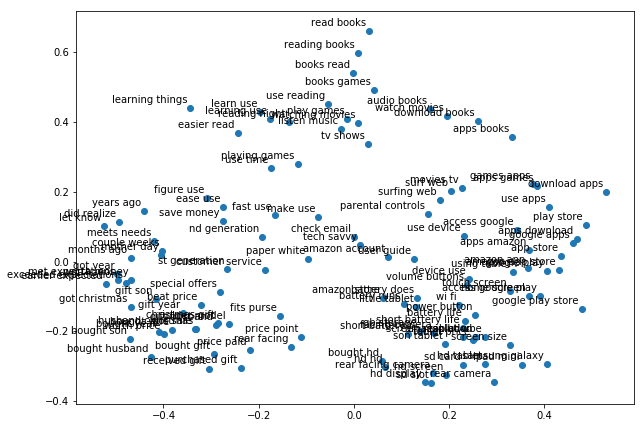

In [28]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

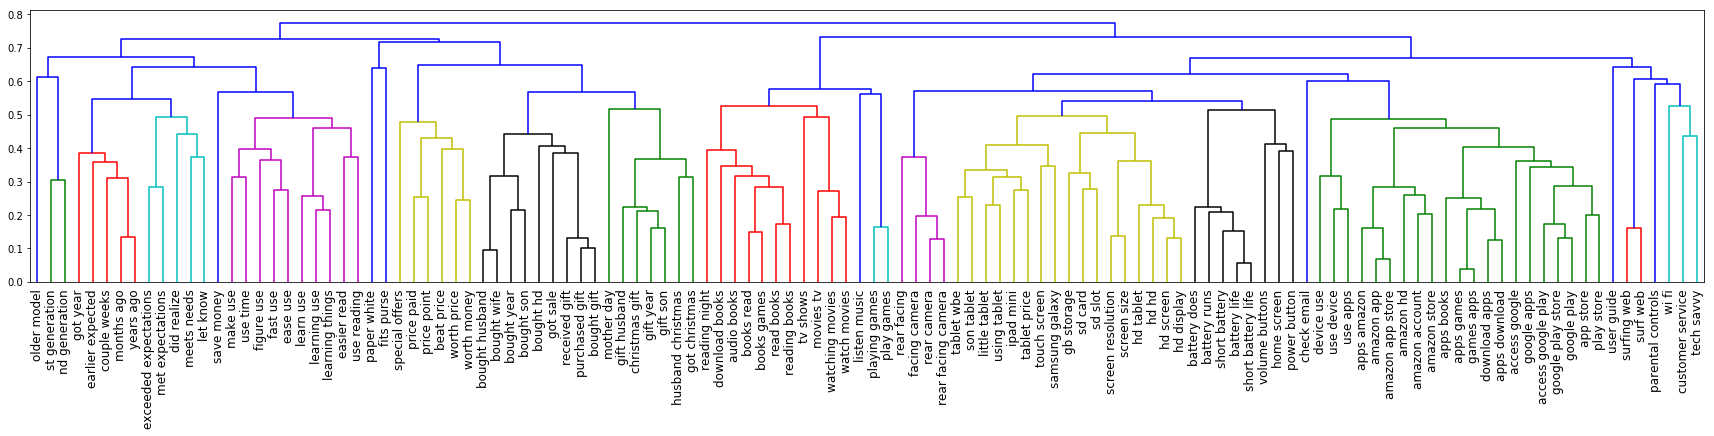

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [30]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [31]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([12, 11, 24, 34,  4,  9, 22, 11,  6,  1, 13, 10,  5,  5, 21, 23,  8,
       27, 14,  0,  0,  6, 13, 33,  4,  1, 11,  0,  7,  1, 20, 17,  1,  3,
        9,  5, 10,  0,  7,  0,  3,  5,  6, 10, 25, 16,  2,  6, 10, 18, 22,
       22,  3, 18,  0,  1, 15, 29, 11,  0,  2,  7, 28,  6,  6, 16, 26,  3,
       34, 10, 12,  5, 14,  1,  1,  3, 14, 12,  5, 34,  2, 14, 23,  5, 28,
       31,  1, 19, 14, 33, 32,  5,  5, 15,  1,  6,  6, 11,  0,  0, 22, 15,
       11,  8,  8, 22, 11, 33, 33, 33, 33,  5, 30, 23, 22, 12, 12,  8,  5,
        5], dtype=int64)

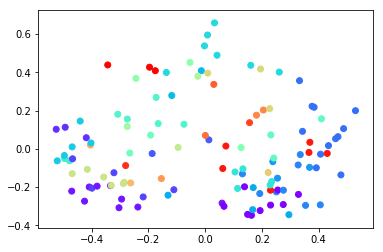

In [32]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [33]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 34


In [34]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [35]:
#df_cluster.to_csv("output/kindle_keywords.csv",index=False)
####### load
df_cluster = pd.read_csv("output/kindle_keywords.csv")
cluster_numbers = np.amax(df_cluster.cluster.tolist())

In [36]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    df_cluster['embedding'] = pd.Series(list(session.run(embed(list(df_cluster['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:45:39.818124  5264 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 5.602092027664185


In [37]:
df_cluster.head()

,term,cluster,embedding
0,battery life,13,"[0.008102105, -0.017975343, -0.046883713, 0.05..."
1,wi fi,24,"[0.033367272, 0.053270333, -0.031291656, 0.054..."
2,customer service,2,"[-0.059746552, 0.060829293, -0.028320795, 0.05..."
3,read books,10,"[0.005046563, -0.0015472032, -0.022233723, 0.0..."
4,learning use,17,"[0.03378463, 0.049826644, -0.05798367, 0.05230..."


In [38]:
group = []
emb_group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    embs_in_group = df_cluster.loc[df_cluster['cluster']==i]['embedding'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        emb_group.append(embs_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['google play', 'app store', 'apps available', 'google apps', 'apps cloud', 'games apps', 'play store', 'use device', 'apps games', 'apps books', 'google play store', 'download apps', 'device use', 'use apps', 'apps download', 'access google play'] 

Group 1:
 ['worth money', 'price point', 'worth price', 'price paid', 'beat price'] 

Group 3:
 ['bought gift', 'bought hd', 'purchased gift', 'got sale', 'received gift'] 

Group 4:
 ['bought son', 'bought husband', 've bought', 'bought wife', 'bought year'] 

Group 5:
 ['volume buttons', 'power button', 'home screen'] 

Group 6:
 ['use time', 'ease use', 'use everyday', 'figure use', 'make use'] 

Group 7:
 ['couldn happier', 'meets needs', 'let know', 'look forward', 'didn realize'] 

Group 9:
 ['years ago', 'months ago', 'earlier expected', 'couple weeks', 'got year'] 

Group 10:
 ['read books', 'reading books', 'download books', 'reading night', 'books read', 'books games', 'audio books'] 

Group 12:
 ['watch movies', 'watch

In [ ]:
test1 = group[1]
test1

In [ ]:
ar1 = np.array([1,2,3,4,5])
ar2 = np.array([2,3,4,5,6])
ar3 = (ar1+ar2)/2
ar3

In [ ]:
np.zeros(5)

In [39]:
avg_embs = []

for embs in emb_group:
    temp_avg = np.zeros(len(embs[0]))
    for term_emb1 in embs:
        temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(embs)
    avg_embs.append(term_avg)

In [40]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[google play, app store, apps available, googl...","[-0.004011161458038259, -0.0006794111832277849..."
1,"[worth money, price point, worth price, price ...","[0.03527632430195808, 0.016698149591684343, -0..."
2,"[bought gift, bought hd, purchased gift, got s...","[-0.007570024067535997, 0.011954319290816784, ..."
3,"[bought son, bought husband, ve bought, bought...","[0.03638900220394135, 0.0066331441979855296, -..."
4,"[volume buttons, power button, home screen]","[-0.043360721319913864, -0.017116015156110127,..."
5,"[use time, ease use, use everyday, figure use,...","[0.021161017008125782, 0.015681708737974986, 0..."
6,"[couldn happier, meets needs, let know, look f...","[0.03414164409041405, -0.014147636981215328, -..."
7,"[years ago, months ago, earlier expected, coup...","[-0.024673841055482627, -0.0026352970860898496..."
8,"[read books, reading books, download books, re...","[-0.004771817342511245, 0.020882075552695563, ..."
9,"[watch movies, watching movies, movies tv, mov...","[-0.02457951381802559, -0.007576396036893129, ..."


In [41]:
import pickle
pickle.dump(cluster_embs, open("output/kindle_cluster_embs.pickle", "wb"))

In [42]:
test_load = pickle.load(open("output/kindle_cluster_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[google play, app store, apps available, googl...","[-0.004011161458038259, -0.0006794111832277849..."
1,"[worth money, price point, worth price, price ...","[0.03527632430195808, 0.016698149591684343, -0..."
2,"[bought gift, bought hd, purchased gift, got s...","[-0.007570024067535997, 0.011954319290816784, ..."
3,"[bought son, bought husband, ve bought, bought...","[0.03638900220394135, 0.0066331441979855296, -..."
4,"[volume buttons, power button, home screen]","[-0.043360721319913864, -0.017116015156110127,..."
5,"[use time, ease use, use everyday, figure use,...","[0.021161017008125782, 0.015681708737974986, 0..."
6,"[couldn happier, meets needs, let know, look f...","[0.03414164409041405, -0.014147636981215328, -..."
7,"[years ago, months ago, earlier expected, coup...","[-0.024673841055482627, -0.0026352970860898496..."
8,"[read books, reading books, download books, re...","[-0.004771817342511245, 0.020882075552695563, ..."
9,"[watch movies, watching movies, movies tv, mov...","[-0.02457951381802559, -0.007576396036893129, ..."


In [43]:
cluster_centers = test_load['avg_emb'].tolist()
cluster_centers_labels = test_load['terms'].tolist()

In [44]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'fireHD-tag'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text','main']]
###################################################

In [45]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
reviews.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:46:48.323152  5264 saver.py:1483] Saver not created because there are no variables in the graph to restore


,text,main,embedding
0,I find that is not as easy to use as my regula...,find is use Kindle Fire,"[0.074233115, 0.06930195, -0.031268492, 0.0549..."
1,When I am reading the kindle it freezes up (be...,am reading kindle freezes hold side,"[0.014984652, 0.0803408, -0.025731513, 0.01954..."
2,Also you have to get out of it to brighten or ...,have get brighten darken text are reading,"[-0.0010017281, 0.047674406, -0.015956037, 0.0..."
3,"Lastly, the advertisements that come up every ...",advertisements come time turn HD Kindle Fire a...,"[0.04314762, 0.056879345, -0.028308257, 0.0254..."
4,Convenient and use the library to download books,use library download books,"[0.052533846, 0.032760903, -0.013839496, 0.053..."


In [46]:
def find_closest(centers, text_emb):
    distances = np.inner(centers,text_emb)
    if np.amax(distances)<=0.5:
        return -1
    else:
        return np.where(distances == np.amax(distances))[0][0]

In [ ]:
test1 = np.inner(cluster_centers,reviews['embedding'].tolist())

In [47]:
reviews['cluster'] = reviews['embedding'].apply(lambda x: find_closest(cluster_centers,x))
reviews

,text,main,embedding,cluster
0,I find that is not as easy to use as my regula...,find is use Kindle Fire,"[0.074233115, 0.06930195, -0.031268492, 0.0549...",11
1,When I am reading the kindle it freezes up (be...,am reading kindle freezes hold side,"[0.014984652, 0.0803408, -0.025731513, 0.01954...",-1
2,Also you have to get out of it to brighten or ...,have get brighten darken text are reading,"[-0.0010017281, 0.047674406, -0.015956037, 0.0...",-1
3,"Lastly, the advertisements that come up every ...",advertisements come time turn HD Kindle Fire a...,"[0.04314762, 0.056879345, -0.028308257, 0.0254...",-1
4,Convenient and use the library to download books,use library download books,"[0.052533846, 0.032760903, -0.013839496, 0.053...",8
5,Should have done this a long time ago,have done time,"[0.00698723, -0.0040228614, -0.043284345, -0.0...",6
6,The video is the best,video is,"[-0.025513561, -0.01481792, -0.024252268, 0.02...",-1
7,I don't bother watching the news on the televi...,do bother watching news television go Kindle Fire,"[0.029989352, 0.08369503, 0.0007162266, 0.0039...",-1
8,Couldn't be happier with this,be,"[0.09142621, -0.02730996, -0.03349693, 0.02173...",6
9,Good reading device and easy to use,reading device use,"[0.04049769, -0.028381255, -0.0344359, 0.05621...",-1


In [48]:
len1 = len(cluster_centers)
clustered_sentences = []
for i in range(len1):
    s1 = reviews.loc[reviews['cluster']==i,['text']]['text'].tolist()
    print('cluster',i,'----  contents:',cluster_centers_labels[i],'\n')
    print(s1)
    print('\n\n')
    temp_str = ''
    for j in range(len(s1)):
        temp_str = temp_str + s1[j] + '. '
    clustered_sentences.append(temp_str)

cluster 0 ----  contents: ['google play', 'app store', 'apps available', 'google apps', 'apps cloud', 'games apps', 'play store', 'use device', 'apps games', 'apps books', 'google play store', 'download apps', 'device use', 'use apps', 'apps download', 'access google play'] 

['All my apps are backed up to google and Amazon will NOT allow google on this tablet', 'Tried an all email app but that was strange to use', 'Wish it had a Google Play store option or option to download Google apps', 'It moves around the internet great, and the apps get the work done I need', 'I wish i was able to download google play apps', 'Wish it had access  to more apps', 'The Android operating system works fine and the apps I use most are available, so no problem there', 'I an really enjoying this, but I am slightly disappointed in the apps available', 'The apps on the Home Screen are easy to relocate if you want to cluster them by types', "Even though there are not nearly as many apps available in the App 

In [49]:
pickle.dump(clustered_sentences, open("output/kindle_clustered_sentences.pickle", "wb"))



In [ ]:
####### corr
corr = np.inner(embs,embs)

In [ ]:
corr[7][26]

In [ ]:
corr[corr<0]=0
corr[corr>0.99]=0

In [ ]:
result = np.where(corr == np.amax(corr))
result[0]

In [ ]:
n_sentence = len(terms)
corr_maxes = np.amax(corr,axis=1)
corr_mins = np.amin(corr,axis=1)
avg_corr = sum(sum(corr))/n_sentence/n_sentence
avg_max_corr = sum(corr_maxes) / n_sentence
avg_min_corr = sum(corr_mins) / n_sentence
print('avg max corr:{}, avg min corr:{}. avg corr:{}'.format(avg_max_corr, avg_min_corr, avg_corr))

In [ ]:
# Clustering
time1 = time.time()
db_w = DBSCAN(eps=0.25, metric='cosine').fit(embs)
print('time for clustering sentence embeddings:', (time.time()-time1))
# Get labels
labels_w = db_w.labels_.tolist()
key_words['label'] = labels_w
key_words

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(np.array(key_words['term'].tolist()),np.array(key_words['embedding'].tolist()),90)

In [ ]:
print(reviews['text'][1193])
print(reviews['text'][1648])

In [ ]:
corr_maxes = np.amax(corr,axis=1)
corr_mins = np.amin(corr,axis=1)
avg_corr = sum(sum(corr))/n_sentence/n_sentence
avg_max_corr = sum(corr_maxes) / n_sentence
avg_min_corr = sum(corr_mins) / n_sentence
print('avg max corr:{}, avg min corr:{}. avg corr:{}'.format(avg_max_corr, avg_min_corr, avg_corr))

In [ ]:
corr_min_of_max = np.amin(corr_maxes)
corr_min_of_max

In [ ]:
np.amax(corr)

In [ ]:
labels = np.zeros(shape=n_sentence, dtype=np.int8)
chain = np.zeros(shape=n_sentence, dtype=np.int8)

the_line = 0.85#0.9*avg_max_corr+0.1*avg_corr
the_line

In [ ]:
np.where(corr > the_line)[0].shape[0]/(n_sentence*n_sentence)

In [ ]:
pairs = np.where(corr > 0.85)

In [ ]:
my_i=4
print(reviews['text'][pairs[0][my_i]])
print(reviews['text'][pairs[1][my_i]])

In [ ]:
def find_close_pt_with_label(s): # s: the index of the sentence
    for i in range(0, n_sentence):
        if corr[s][i]>the_line and labels[i]!=0:
            return i,labels[i]
    return 0, 0

def group_labels(labels):
    clusters = []
    for i in range(-1,np.amax(labels)):
        index = np.where(labels == i)
        clusters.append(index[0])
    return clusters

In [ ]:
label_count = 1
current_label=0

for i in range(0,n_sentence):
    if np.amax(corr[i])<0.85:
        labels[i] = -1 
        continue
    #######check if we should skip to next ####################
    if labels[i]!= 0: # if i already has a label
        continue
    ######or need to find the current sentence a label########
    else:
        (index_, temp) = find_close_pt_with_label(i) # try to find i an existing label
        if temp!=0:
            labels[i] = temp
            chain[i] = 1+chain[index_]
            if chain[i]>1: #1: # does not allow 2+ chain
                labels[i] = label_count
                label_count = label_count+1
        else:
            labels[i] = label_count # else, assign a new label
            label_count = label_count+1
    ###### finished assigning the current sentence a label#########
    
    current_label = labels[i]
    ###### move on to spread the label  ###########################
    for j in range(i, n_sentence):
        if labels[j]!=0: # if j already has a label
            continue # skip
        if corr[i][j]>the_line: # if sentence i is similar to sentence j enough
            if labels[j]==0: # if sentence j doesn't have a label
                labels[j] = current_label
                

In [ ]:
clusters = group_labels(labels)

In [ ]:
len(clusters)

In [ ]:
clusters

In [ ]:
clusters[1].shape[0]

In [ ]:
loose = []
remove_group = []
for i in range(0,len(clusters)):
    if clusters[i].shape[0]<10:
        for j in range(0,clusters[i].shape[0]):
            loose.append(clusters[i][j])
        remove_group.append(i)
        
loose = np.array(loose)

In [ ]:
clusters = np.array(clusters)
clusters = np.delete(clusters, remove_group, 0)
clusters = clusters.tolist()
clusters.append(loose)

In [ ]:
clusters

In [ ]:
##############save##############
product_title='Fire HD'
params='greedy-cosine'
dir1 = save_results_dir(product_title,'similarity',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,len(clusters)):    
    temp = reviews.loc[clusters[i].tolist(),['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

#################################

In [ ]:
pca = dc.PCA(n_components=10)
pca.fit(X1)
X1 = pca.transform(X1)

pca = dc.PCA(n_components=10)
pca.fit(X2)
X2 = pca.transform(X2)

n_sentence = len(X2.tolist())
import math
n_min_pts = math.ceil(n_sentence*0.01)

print('number of sentences:{}, min points:{}'.format(n_sentence,n_min_pts))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(np.array(reviews['text'].tolist())[0:50],np.array(reviews['sentence_embedding'].tolist())[0:50],90)

In [ ]:
label_s = np.array([])
label_w = np.array([])


def cluster_number(labels):
    return (len(set(labels)) - (1 if -1 in labels else 0))



In [ ]:
print('total sentences:',len(list(labels_s)))
print('clusters for sentences:',n_sentence, 'noise:',list(labels_s).count(-1))
print('clusters for words:',n_words, 'noise:',list(labels_w).count(-1))

In [ ]:
def save_results_dir(product_name, method, params):
    dir_pre = '/home/betty35/桌面/Capstone/workspace/data_testing/output/'
    dir_ = dir_pre+product_name+'/'+method+'/'+params+'/'
    return dir_


def make_dir(dir_):
    if not os.path.exists(dir_):
        try:
            os.makedirs(dir_)
        except FileExistsError:
            pass

def clean_dir(dir_):
    for file_ in os.listdir(dir_):
        file_dir = os.path.join(dir_, file_)
        try:
            if os.path.isfile(file_dir):
                os.unlink(file_dir)
            elif os.path.isdir(file_dir): shutil.rmtree(file_dir)
        except Exception as e:
            print(e)

def make_or_clean_dir(dir_):
    make_dir(dir_)
    clean_dir(dir_)
    

In [ ]:
product_title='Fire HD'
params='0.27-PCA10'
dir1 = save_results_dir(product_title,'dbscan',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,n_sentence):    
    temp = reviews.loc[reviews['label_db_sentence']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

noise_s = temp = reviews.loc[reviews['label_db_sentence']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

dir1 = save_results_dir(product_title,'dbscan',params+'/word')
make_or_clean_dir(dir1)
for i in range(0,n_words):
    temp = reviews.loc[reviews['label_db_word']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')
noise_s = temp = reviews.loc[reviews['label_db_word']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

In [ ]:
def cal_distance(X250):
    